<a href="https://colab.research.google.com/github/KhanShaheb34/NumtaGAN/blob/main/NumtaGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NumtaGAN (Generative Adversarial Network)

Creating a GAN to generate bangla digits.

Dataset: [Numta - Bengali.ai](https://bengali.ai/datasets/)

Dataset Paper: [Numta - Assembled Bangla Handwritten Digits](https://bengali.ai/wp-content/uploads/datasets/assembled-bangla-handwritten.pdf)

GAN Paper: [Generative Adversarial Nets](https://papers.nips.cc/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf)

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython import display
import time
%matplotlib inline

# Generator

This part will take a latent space (1D array with 100 elements) as input and generate a (28*28*1) shaped noise. And eventually, it will increase it's precission by training and generate actual images looks like bangla digits

In [42]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Reshape

In [43]:
IMAGE_SHAPE = (28, 28, 1)
INPUT_SHAPE = (100, )
CAPACITY = 28*28*1

generator = Sequential()

generator.add(Dense(128, activation='relu', input_shape=INPUT_SHAPE))
generator.add(BatchNormalization())
generator.add(Dense(256, activation='relu'))
generator.add(BatchNormalization())
generator.add(Dense(512, activation='relu'))
generator.add(BatchNormalization())
generator.add(Dense(1024, activation='relu'))
generator.add(BatchNormalization())
generator.add(Dense(CAPACITY, activation='relu'))
generator.add(Reshape(IMAGE_SHAPE))

generator.compile(optimizer='adam', loss='binary_crossentropy')
generator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               12928     
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
dense_10 (Dense)             (None, 256)               33024     
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
dense_11 (Dense)             (None, 512)               131584    
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
dense_12 (Dense)             (None, 1024)             

## Discriminator

This part will discriminate between the random noise generated by the [generator](#generator), train itself and help training the generator during the gan training process.

In [44]:
from keras.layers import Flatten

In [45]:
discriminator = Sequential()

discriminator.add(Flatten(input_shape = IMAGE_SHAPE))
discriminator.add(Dense(CAPACITY, input_shape=(CAPACITY, )))
discriminator.add(Dense(CAPACITY / 2, activation='relu'))
discriminator.add(Dense(CAPACITY / 4, activation='relu'))
discriminator.add(Dense(1, activation='sigmoid'))

discriminator.compile(optimizer='adam', loss='binary_crossentropy')
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 784)               615440    
_________________________________________________________________
dense_15 (Dense)             (None, 392)               307720    
_________________________________________________________________
dense_16 (Dense)             (None, 196)               77028     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 197       
Total params: 1,000,385
Trainable params: 1,000,385
Non-trainable params: 0
_________________________________________________________________


## GAN

This is where we attatch the generator and discriminator.

In [46]:
gan = Sequential()

discriminator.trainable = False
generator.trainable = True

gan.add(generator)
gan.add(discriminator)

gan.compile(optimizer='adam', loss='binary_crossentropy')
gan.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 28, 28, 1)         1514128   
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 1000385   
Total params: 2,514,513
Trainable params: 1,510,288
Non-trainable params: 1,004,225
_________________________________________________________________


## Load Dataset

And have a look at a example.

In [7]:
!unzip bangla_digit_dataset.zip

Archive:  bangla_digit_dataset.zip
  inflating: test_images.txt         
  inflating: test_labels.txt         
  inflating: train_images.txt        
  inflating: train_labels.txt        


Shape:  (26475, 28, 28, 1)


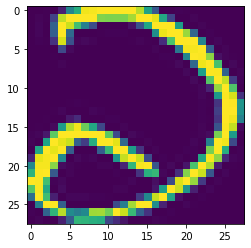

In [87]:
train_x = pd.read_csv('train_images.txt', sep=' ').to_numpy()
test_x = pd.read_csv('test_images.txt', sep=' ').to_numpy()

dataset = np.concatenate((train_x, test_x)).reshape(26475, 28, 28, 1) / 255
print("Shape: ",  dataset.shape)
plt.imshow(dataset[0].reshape(28, 28))

## Training

It's time to train the GAN. Have a look at the details about training.

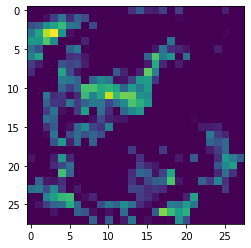

In [84]:
epochs = 1000
desc_epochs = 5
batch_size = 32
image_count = 26475
latent_space_size = 100

for epoch in range(epochs):
  for step in range(desc_epochs):
    latent_space_sample = np.random.rand(batch_size, latent_space_size)
    noise_sample = generator.predict(latent_space_sample)
    real_sample = dataset[np.random.choice(image_count, batch_size)]

    desc_x = np.concatenate((noise_sample, real_sample))
    desc_y = np.concatenate((np.zeros((batch_size, 1)), np.ones((batch_size, 1))))

    discriminator_loss = discriminator.train_on_batch(desc_x, desc_y)

  latent_space_sample = np.random.rand(batch_size*2, latent_space_size)
  gan_y = np.ones((batch_size * 2))
  generator_loss = gan.train_on_batch(latent_space_sample, gan_y)

  if(epoch%100 == 0):
    print(f"Epoch {epoch+1}:")
    print(f"\tDiscriminator loss: {discriminator_loss}\n\tGenerator Loss: {generator_loss}")

    try:
      noise_sample = generator.predict(np.random.rand(1, 100)) 
      plt.imshow(noise_sample[0].reshape(28, 28))
      display.display(plt.gcf())
      display.clear_output(wait=True)
      time.sleep(1)
    except KeyboardInterrupt:
      break

## Test

Let's have a look at some of the examples to test how our GAN is performing.

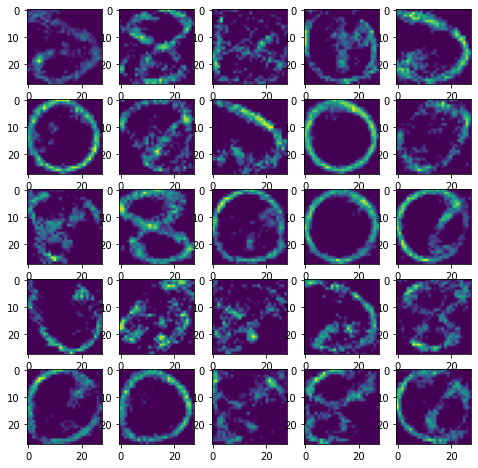

In [85]:
noise_sample = generator.predict(np.random.rand(26, 100))

fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(noise_sample[i].reshape(28, 28))
plt.show()

I don't know why but it seems like ০, ৪, ১ and ৫ are the most favourite digits of our GAN. 😛

## Want to learn more about GAN?

* Read the paper
* Here's a [good playlist](https://www.youtube.com/playlist?list=PL6jyd5IQRqw1j7qfhzTbp9ht5vmcOubcR) about GAN in Bangla